# KOSPI index from scratch

## 0. Import libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import streamlit as st

In [3]:
import FinanceDataReader as fdr
import quantstats as qs

In [4]:
## custom libs

from korquanttools.pricevolume.loader import KRXPriceDM
from korquanttools.pricevolume.utils import DateUtil
from korquanttools.pricevolume.config import PathConfig

## 1. Import datasets

- Import price-volume data module from KRX using custom lib `korquanttools`
- Load/derive price, volume, market cap, dollar volume, etc from the dataset

In [5]:
# Global parameters

START = 20140101
END = 20220520

In [6]:
# Init data module
pricevolume = KRXPriceDM(START, END)
pricevolume.get_info()


        * DM name: KRX_pricevolume
        * DM description: Basic price-volume data imported from KRX website & NAVER finance. Has KOSPI, KOSDAQ, KONEX stocks.
        * birthday: 20211203
        * DM period: 19990101 ~ 
        * Available data: ['lv1', 'open', 'high', 'low', 'close', 'volume', 'dollarvolume', 'marketcap']
        


- close price / market cap 

In [9]:
close_df = pricevolume.get_data("close")
close_df = close_df.astype(float)

marketcap_df = pricevolume.get_data('marketcap') # TODO: 현재 object로 불러와져 직접 astype(float) 해줘야 함. fix it. 
marketcap_df = marketcap_df.astype(float)

- KOSPI, KOSDAQ universe

In [10]:
lv1_df = pricevolume.get_data('lv1')

In [11]:
market_cat_df = lv1_df[['ISU_SRT_CD', 'MKT_NM', 'trdDd']].copy()

In [12]:
market_cat_df['MKT_NM'].unique()

array(['KOSDAQ', 'KOSPI', 'KONEX'], dtype=object)

In [13]:
market_cat_df.loc[:, 'is_KOSPI'] = (market_cat_df['MKT_NM'] == 'KOSPI')
market_cat_df.loc[:, 'is_KOSDAQ'] = (market_cat_df['MKT_NM'] == 'KOSDAQ')
market_cat_df.loc[:, 'is_KONEX'] = (market_cat_df['MKT_NM'] == 'KONEX')

In [14]:
kospi_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KOSPI')
kosdaq_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KOSDAQ')
konex_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KONEX')


- tradingday DM by processing `pricevolume`


In [15]:
holidays = close_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

- KOSPI index data

In [16]:
kospi_index = fdr.DataReader('KS11', DateUtil.numdate2stddate(START), DateUtil.numdate2stddate(END))
kospi_index = kospi_index['Close']

In [17]:
kospi_firstday_value = kospi_index[0]
kospi_firstday_value

1967.19

## 2. KOSPI construction - the WRONG way

In [18]:
kospi_marketcap_df = marketcap_df[kospi_univ_df]
kospi_marketcap_df = kospi_marketcap_df.loc[tradingdays, :]

- Simple market cap weighted construction 
- Does not consider newly listed/delisted stocks

In [46]:
kospi_calculated_wrong = kospi_marketcap_df.sum(axis=1)
normalize_coef = kospi_firstday_value / kospi_calculated_wrong.iloc[0]
kospi_calculated_wrong = kospi_calculated_wrong * normalize_coef
kospi_calculated_wrong[-1] = np.nan

In [47]:
kospi_compare_df = kospi_index.to_frame()
kospi_compare_df.rename({'Close': 'real_kospi'}, inplace=True, axis=1)

kospi_compare_df['calculated_kospi'] = kospi_calculated_wrong

kospi_compare_df['difference'] = kospi_compare_df['real_kospi'] - kospi_compare_df['calculated_kospi']


<AxesSubplot:xlabel='Date'>

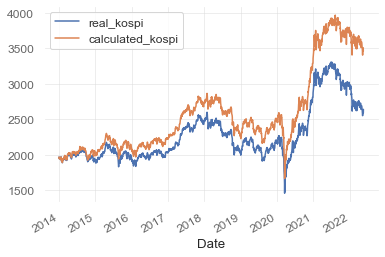

In [50]:
kospi_compare_df[['real_kospi', 'calculated_kospi']].plot()

<AxesSubplot:xlabel='Date'>

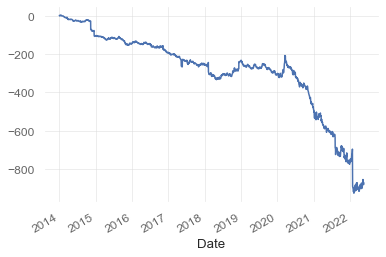

In [49]:
kospi_compare_df['difference'].plot()

Calculated KOSPI DOES NOT match real KOSPI index. 

The shape is mostly the same, but you can see it is "stretched" up/down. This is because standard market cap value is not adjusted. 

The difference is very big and it gets bigger and bigger. 

## 3. KOSPI construction - the RIGHT way

KOSPI rebalance adjustment follows this formula:

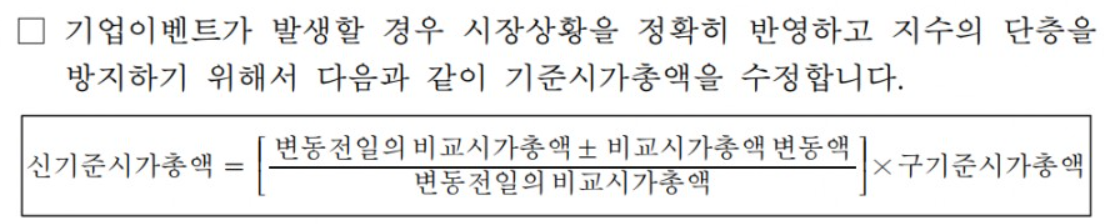

### 3-1. Calculated KOSPI by adjusting newly listed/delisted stocks

In [20]:
kospi_marketcap_df = marketcap_df[kospi_univ_df]
kospi_marketcap_df = kospi_marketcap_df.loc[tradingdays, :]

kospi_marketcap_2d =  np.array(kospi_marketcap_df)

In [21]:
existance_arr = np.array(kospi_marketcap_df.isna()) # Whether a certain ii exists on di
universe_diffs = np.zeros_like(existance_arr) * 1 # The day after new listing/delist is recorded  (Calculated below)
# TODO: Change name to something like rebalance to avaoid confusion. 

for di in range(len(existance_arr[:-1])):
    diff = (existance_arr[di] * 1) -(existance_arr[di+1] * 1) # astype(int) 대신 1을 곱해줌
    # 신규상장시 1, 상장폐지시 -1, 아무 일 없으면 0
    universe_diffs[di+1] = diff * 1


In [22]:
adj_marketcap_2d = np.zeros_like(kospi_marketcap_2d)
adj_marketcap_2d[0] = np.nan

for di in range(1, len(universe_diffs)):
    rebalance_row = universe_diffs[di]
    
    adj_marketcap_2d[di] = np.where(rebalance_row == 1, kospi_marketcap_2d[di], # nested np.where if/elif/else
                            np.where(rebalance_row == -1, -kospi_marketcap_2d[di-1], np.nan))

In [23]:
adj_sums = np.nansum(adj_marketcap_2d, axis=1)
marcap_sums = np.nansum(kospi_marketcap_2d, axis=1)

In [34]:
created_std_marcaps = []
created_kospi_values = []

std_marcap_latest = kospi_marketcap_df.sum(axis=1)[0]
for di in range(1, len(marcap_sums)):
    marcap = marcap_sums[di]
    marcap_yesterday = marcap_sums[di-1]
    diff = adj_sums[di]

    new_std_marcap = std_marcap_latest * (marcap_yesterday + diff) / marcap_yesterday
    new_index = kospi_firstday_value * (marcap_yesterday + diff) / new_std_marcap
    std_marcap_latest = new_std_marcap

    created_std_marcaps.append(new_std_marcap)
    created_kospi_values.append(new_index)

created_kospi_values.append(np.nan)

C:\Users\chlje\AppData\Local\Temp\ipykernel_7996\656804950.py:11: RuntimeWarning: invalid value encountered in double_scalars
  new_index = kospi_firstday_value * (marcap_yesterday + diff) / new_std_marcap


In [51]:
kospi_compare_df = kospi_index.to_frame()
kospi_compare_df.rename({'Close': 'real_kospi'}, inplace=True, axis=1)

kospi_compare_df['calculated_kospi'] = created_kospi_values

kospi_compare_df['difference'] = kospi_compare_df['real_kospi'] - kospi_compare_df['calculated_kospi']


<AxesSubplot:xlabel='Date'>

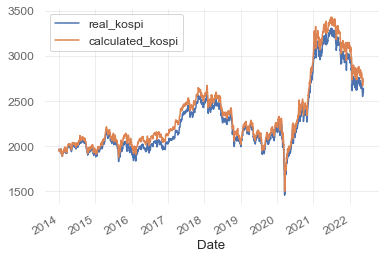

In [52]:
kospi_compare_df[['real_kospi', 'calculated_kospi']].plot()

<AxesSubplot:xlabel='Date'>

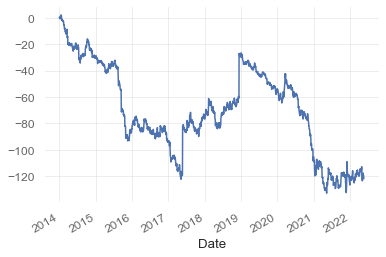

In [53]:
kospi_compare_df['difference'].plot()

You can see that `calculated_kospi` almost follows `real_kospi`. 

Though there are differences, it is smaller than before and it does not get bigger as time goes by. 

These differences are the result of ____

### 3-2. How does it work?

You can see it works, but understanding how it works is not easy because data is too big. 

We can use small sample dataset to see how it works. 

`sample_kospi_marketcap_2d` doesn't have any price changes, so the sample index should ALWAYS be 1234. 

(All the market cap changes are coming from newly listed/delisted stocks)

In [54]:
sample_kospi_marketcap_2d = np.array([
    [600, 400, np.nan, np.nan],
    [600, 400, np.nan, np.nan], # delisted!
    [600, np.nan, np.nan, np.nan],
    [600, np.nan, np.nan, np.nan],
    [600, np.nan, 500, np.nan], # newly listed!
    [600, np.nan, 500, np.nan], # delisted!
    [600, np.nan, np.nan, np.nan],
    [600, np.nan, np.nan, np.nan],
    [600, np.nan, np.nan, 100], # newly listed!
    [600, np.nan, np.nan, 100],
    [600, np.nan, np.nan, 100],
])

sample_kospi_marketcap_2d

array([[600., 400.,  nan,  nan],
       [600., 400.,  nan,  nan],
       [600.,  nan,  nan,  nan],
       [600.,  nan,  nan,  nan],
       [600.,  nan, 500.,  nan],
       [600.,  nan, 500.,  nan],
       [600.,  nan,  nan,  nan],
       [600.,  nan,  nan,  nan],
       [600.,  nan,  nan, 100.],
       [600.,  nan,  nan, 100.],
       [600.,  nan,  nan, 100.]])

In [55]:
existance_arr = np.isnan(sample_kospi_marketcap_2d)
existance_arr

array([[False, False,  True,  True],
       [False, False,  True,  True],
       [False,  True,  True,  True],
       [False,  True,  True,  True],
       [False,  True, False,  True],
       [False,  True, False,  True],
       [False,  True,  True,  True],
       [False,  True,  True,  True],
       [False,  True,  True, False],
       [False,  True,  True, False],
       [False,  True,  True, False]])

In [56]:
existance_arr = np.isnan(sample_kospi_marketcap_2d)
existance_arr

array([[False, False,  True,  True],
       [False, False,  True,  True],
       [False,  True,  True,  True],
       [False,  True,  True,  True],
       [False,  True, False,  True],
       [False,  True, False,  True],
       [False,  True,  True,  True],
       [False,  True,  True,  True],
       [False,  True,  True, False],
       [False,  True,  True, False],
       [False,  True,  True, False]])

In [57]:
universe_diffs = np.zeros_like(existance_arr) * 1 # TODO: Change name to something like rebalance to avaoid confusion. 

for di in range(len(existance_arr[:-1])):
    diff = (existance_arr[di] * 1) -(existance_arr[di+1] * 1) # astype(int) 대신 1을 곱해줌
    # 신규상장시 1, 상장폐지시 -1 됨. 
    universe_diffs[di+1] = diff * 1

universe_diffs


array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  1,  0],
       [ 0,  0,  0,  0],
       [ 0,  0, -1,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  1],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0]])

In [58]:
adj_marketcap_2d = np.zeros_like(sample_kospi_marketcap_2d)
adj_marketcap_2d[0] = np.nan

for di in range(1, len(universe_diffs)):
    rebalance_row = universe_diffs[di]
    
    adj_marketcap_2d[di] = np.where(rebalance_row == 1, sample_kospi_marketcap_2d[di], # nested np.where if/elif/else
                            np.where(rebalance_row == -1, -sample_kospi_marketcap_2d[di-1], np.nan))

adj_marketcap_2d

array([[  nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan],
       [  nan, -400.,   nan,   nan],
       [  nan,   nan,   nan,   nan],
       [  nan,   nan,  500.,   nan],
       [  nan,   nan,   nan,   nan],
       [  nan,   nan, -500.,   nan],
       [  nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,  100.],
       [  nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan]])

In [59]:
adj_sums = np.nansum(adj_marketcap_2d, axis=1)
adj_sums

array([   0.,    0., -400.,    0.,  500.,    0., -500.,    0.,  100.,
          0.,    0.])

In [64]:
marcap_sums = np.nansum(sample_kospi_marketcap_2d, axis=1)
marcap_sums

array([1000., 1000.,  600.,  600., 1100., 1100.,  600.,  600.,  700.,
        700.,  700.])

In [68]:
created_std_marcaps = []
created_kospi_values = []

index = 1234
std_marcap_latest = np.nansum(sample_kospi_marketcap_2d, axis=1)[0]
for di in range(1, len(marcap_sums)):
    marcap = marcap_sums[di]
    marcap_yesterday = marcap_sums[di-1]
    diff = adj_sums[di]

    new_std_marcap = std_marcap_latest * (marcap_yesterday + diff) / marcap_yesterday
    new_index = index * (marcap_yesterday + diff) / new_std_marcap
    std_marcap_latest = new_std_marcap

    created_std_marcaps.append(new_std_marcap)
    created_kospi_values.append(new_index)

In [69]:
for i, (std_marcap, kospi) in enumerate(zip(created_std_marcaps, created_kospi_values)):
    print(f'Day {i}: 기준시가총액: {std_marcap} / 샘플 코스피지수: {kospi}')

Day 0: 기준시가총액: 1000.0 / 샘플 코스피지수: 1234.0
Day 1: 기준시가총액: 600.0 / 샘플 코스피지수: 1234.0
Day 2: 기준시가총액: 600.0 / 샘플 코스피지수: 1234.0
Day 3: 기준시가총액: 1100.0 / 샘플 코스피지수: 1234.0
Day 4: 기준시가총액: 1100.0 / 샘플 코스피지수: 1234.0
Day 5: 기준시가총액: 600.0 / 샘플 코스피지수: 1234.0
Day 6: 기준시가총액: 600.0 / 샘플 코스피지수: 1234.0
Day 7: 기준시가총액: 700.0 / 샘플 코스피지수: 1234.0
Day 8: 기준시가총액: 700.0 / 샘플 코스피지수: 1234.0
Day 9: 기준시가총액: 700.0 / 샘플 코스피지수: 1234.0
